# Introduction to Python and Natural Language Technologies

__Lecture 9, Transformers, BERT__

__April 13, 2021__

__Judit Ács__

In [1]:
import gc
from IPython.display import Image
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn

from transformers import pipeline
from transformers import AutoTokenizer, AutoModel

# Attention mechanism

Attention:
- emphasizes the important part of the input
- and de-emphasizes the rest.
- Mimics cognitive attention.

Method:
- It does this by assigning weights to the elements of the input sequence.
- The weights depend on the current context in the decoder:
    - the current decoder hidden state,
    - the previous output.
- The source vectors are multiplied by the weights and then summed -> **context vector**
- The context vector is used for predicting the next output symbol.

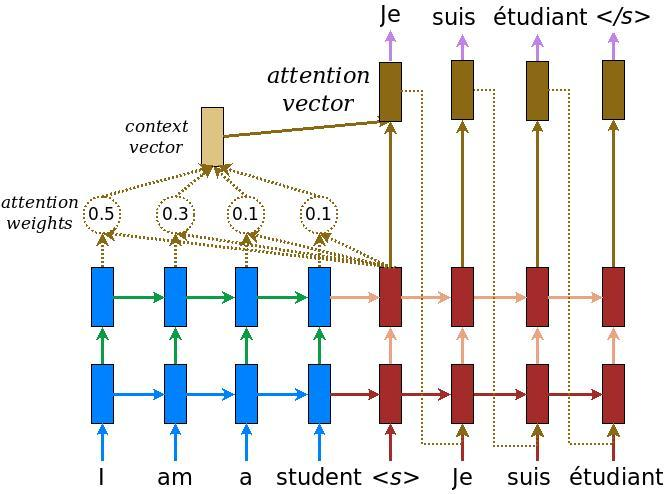

In [2]:
Image("img/dl/attention_mechanism.jpg")

## Problems

Recall that we used recurrent neural cells, specifically LSTMs to encode and decode sequences.

__Problem 1. No parallelism__

LSTMs are recurrent, they rely on their left and right history (horizontal arrows), so the symbols need to be processed in order -> no parallelism.

__Problem 2. Long-range dependencies__

Long-range dependencies are not infrequent in NLP.

"The **people/person** who called and wanted to rent your house when you go away next year **are/is** from California" -- Miller & Chomsky 1963

LSTMs have a problem capturing these because there are too many backpropagation steps between the symbols.

# Transformers

Introduced in [Attention Is All You Need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) by Vaswani et al., 2017

Transformers solve Problem 1 by relying purely on attention instead of recurrence.

Not having recurrent connections means that sequence position no longer matters.

Recurrence is replaced by **self attention**.

Each symbol is encoded the following way:

__Step 1__: the encoder 'looks' at the other symbols in the input sequence
    - In the example above: the representation of **are/is** depends on **people/person** more than any other word in the sentence, it should receive the highest attention weight.

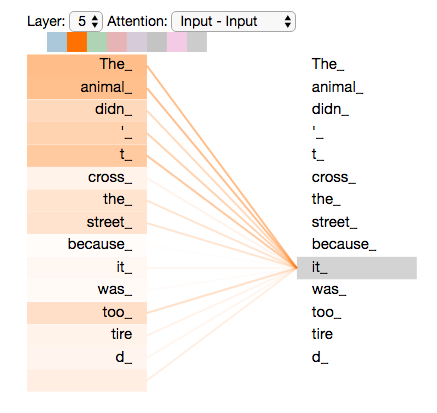

In [3]:
Image("http://jalammar.github.io/images/t/transformer_self-attention_visualization.png", embed=True)  # from Illustrated Transformers

__Step 2__: the context vector is passed through a feed-forward network which is shared across all symbols.

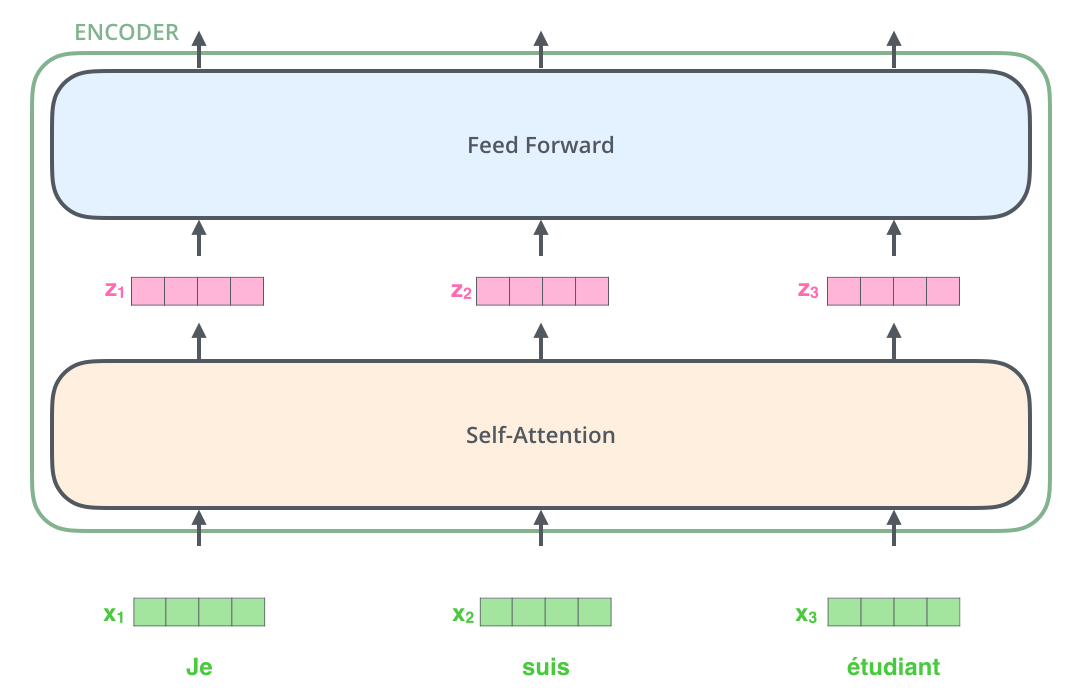

In [4]:
Image("http://jalammar.github.io/images/t/encoder_with_tensors.png", embed=True)  # from Illustrated Transformers

This visualization is available in the [Tensor2tensor notebook in Google Colab](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)

## Other components

__Residual connections__

- Also called __skip connections__
- The output of a module is added to the input

$$
\text{output} = \text{layer}(\text{input}) + \text{input}
$$

__Softmax__

- Only used in the decoder
- Maps the output vector to a probability distribution
    - In other words it tells us how likely each symbol is.

## Multiple heads and layers

Transformers have a number of additional components summarized in this figure:

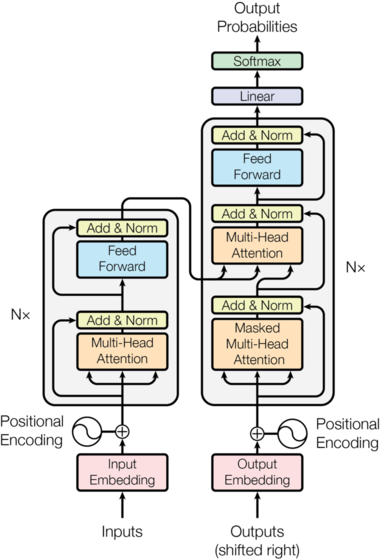

In [5]:
Image("img/dl/transformer.png")  # from Vaswani et al. 2018

## PyTorch support

PyTorch has a `nn.Transformer` class and its encoder and decoder versions.

In [6]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [9]:
embedding_dim = 12
# num_heads = 5  # embedding_dim must be divisible by the number of heads
num_heads = 2
hidden_size = 7
dropout = 0.2
TransformerEncoderLayer(embedding_dim, num_heads, hidden_size, dropout)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=12, out_features=12, bias=True)
  )
  (linear1): Linear(in_features=12, out_features=7, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=7, out_features=12, bias=True)
  (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [10]:
layer = TransformerEncoderLayer(embedding_dim, num_heads, hidden_size, dropout)
TransformerEncoder(layer, 2)

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=12, out_features=12, bias=True)
      )
      (linear1): Linear(in_features=12, out_features=7, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (linear2): Linear(in_features=7, out_features=12, bias=True)
      (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): _LinearWithBias(in_features=12, out_features=12, bias=True)
      )
      (linear1): Linear(in_features=12, out_features=7, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (linear2): Linear(in_features=7, out_features=12, bias=True)
      (norm1): LayerNorm((12,), ep

In [11]:
encoder = TransformerEncoder(layer, 2)

sequence_len = 9
batch_size = 3
X = torch.rand((sequence_len, batch_size, embedding_dim))
y = encoder(X)
y.size()

torch.Size([9, 3, 12])

## Positional encoding

Without recurrence word order information is lost.

Positional information is important:

    John loves Mary.
    Mary loves John.

Transformers apply positional encoding:

$$
\text{PE}_{\text{pos},2i} = \sin(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}), \\
\text{PE}_{\text{pos},2i+1} = \cos(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}),
$$

where:
- $d_{\text{model}}$ is the input dimension to the Transformer, usually the embedding size
- $\text{pos}$ is the position of the symbol in the input sequence i.e. first word, second word etc.
- $i$ is the coordinate index in the input vector.

Let's create a position encoder in PyTorch.

For $\text{pos}=0$, the sine values are 0, and the cosine values are 1:

In [12]:
t = torch.FloatTensor([0.])
torch.cos(t), torch.sin(t)

(tensor([1.]), tensor([0.]))

For large $i$ values, the denominator is close to 10000, so it's again close to 0.

In [15]:
# Pick a few random values for pos
pos = torch.randint(512, size=(10, ))
print(pos)

# Divide by 10000^2*i/d_model. Make 2*i/d_model close to one (high 2*i values)
t = pos / (10000 ** 0.95)
print(t)
torch.cos(t), torch.sin(t)

tensor([445, 109, 251,  47,  17,  42, 412, 231, 155, 230])
tensor([0.0705, 0.0173, 0.0398, 0.0074, 0.0027, 0.0067, 0.0653, 0.0366, 0.0246,
        0.0365])


(tensor([0.9975, 0.9999, 0.9992, 1.0000, 1.0000, 1.0000, 0.9979, 0.9993, 0.9997,
         0.9993]),
 tensor([0.0705, 0.0173, 0.0398, 0.0074, 0.0027, 0.0067, 0.0653, 0.0366, 0.0246,
         0.0364]))

Let's generate the full grid. There are $\text{maxlen} \times d_\text{model}$ values.

__maxlen__ is the maximum position we allow. This has to be predefined.

__d_model__ is the size of the input, which is embedding_dim in most cases.

In [18]:
maxlen = 20
d_model = 12

pe = torch.zeros((maxlen, d_model))
pe.dtype, pe.size()

(torch.float32, torch.Size([20, 12]))

__pos__ are the indices of the sequence from 0 to $\text{maxlen}-1$:

In [19]:
pos = torch.arange(maxlen, dtype=torch.float)
pos

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

Reminder:

$$
\text{PE}_{\text{pos},2i} = \sin(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}), \\
\text{PE}_{\text{pos},2i+1} = \cos(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}),
$$

Let's define the denominator:

In [20]:
divterm = 10000 ** (torch.arange(0, d_model, step=2) / float(d_model))
divterm

tensor([1.0000e+00, 4.6416e+00, 2.1544e+01, 1.0000e+02, 4.6416e+02, 2.1544e+03])

In [24]:
pos.size(), divterm.size()
print((pos[:, None] / divterm).size())
pos[:, None] / divterm

torch.Size([20, 6])


tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.1544e-01, 4.6416e-02, 1.0000e-02, 2.1544e-03, 4.6416e-04],
        [2.0000e+00, 4.3089e-01, 9.2832e-02, 2.0000e-02, 4.3089e-03, 9.2832e-04],
        [3.0000e+00, 6.4633e-01, 1.3925e-01, 3.0000e-02, 6.4633e-03, 1.3925e-03],
        [4.0000e+00, 8.6177e-01, 1.8566e-01, 4.0000e-02, 8.6177e-03, 1.8566e-03],
        [5.0000e+00, 1.0772e+00, 2.3208e-01, 5.0000e-02, 1.0772e-02, 2.3208e-03],
        [6.0000e+00, 1.2927e+00, 2.7850e-01, 6.0000e-02, 1.2927e-02, 2.7850e-03],
        [7.0000e+00, 1.5081e+00, 3.2491e-01, 7.0000e-02, 1.5081e-02, 3.2491e-03],
        [8.0000e+00, 1.7235e+00, 3.7133e-01, 8.0000e-02, 1.7235e-02, 3.7133e-03],
        [9.0000e+00, 1.9390e+00, 4.1774e-01, 9.0000e-02, 1.9390e-02, 4.1774e-03],
        [1.0000e+01, 2.1544e+00, 4.6416e-01, 1.0000e-01, 2.1544e-02, 4.6416e-03],
        [1.1000e+01, 2.3699e+00, 5.1057e-01, 1.1000e-01, 2.3699e-02, 5.1057e-03],
        [1.2000e

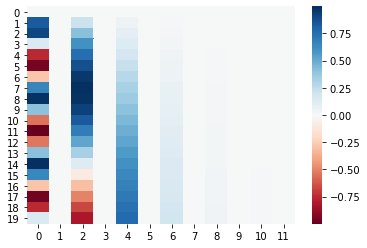

In [26]:
pe[:, ::2] = torch.sin(pos[:, None] / divterm)
sns.heatmap(pe, cmap='RdBu', center=0)

In [30]:
pe[:, 10:]

tensor([[0.0000, 0.0000],
        [0.0005, 0.0000],
        [0.0009, 0.0000],
        [0.0014, 0.0000],
        [0.0019, 0.0000],
        [0.0023, 0.0000],
        [0.0028, 0.0000],
        [0.0032, 0.0000],
        [0.0037, 0.0000],
        [0.0042, 0.0000],
        [0.0046, 0.0000],
        [0.0051, 0.0000],
        [0.0056, 0.0000],
        [0.0060, 0.0000],
        [0.0065, 0.0000],
        [0.0070, 0.0000],
        [0.0074, 0.0000],
        [0.0079, 0.0000],
        [0.0084, 0.0000],
        [0.0088, 0.0000]])

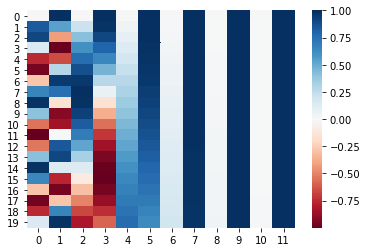

In [32]:
pe[:, 1::2] = torch.cos(pos[:, None] / divterm)
sns.heatmap(pe, cmap='RdBu', center=0)

Combining it in a `nn.Module`:

In [34]:
# took inspiration from here: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, maxlen=50):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(maxlen, d_model)
        pos = torch.arange(maxlen, dtype=torch.float)
        divterm = 10000 ** (torch.arange(0, d_model, step=2) / float(d_model))
        pe[:, ::2] = torch.sin(pos[:, None] / divterm)
        pe[:, 1::2] = torch.cos(pos[:, None] / divterm)
        
        # Since pe is a constant value not a parameter of the module, we register it as a buffer.
        # Buffers are part of the state dictionary of the module along with parameters.
        # Docs: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # The input sequence may be shorter than maxlen
        seqlen = x.size(0)
        
        # The middle dimension is the batch size.
        # We add it as a dummy dimension.
        x = x + self.pe[:seqlen, None, :]
        return self.dropout(x)

In [39]:
d_model = 12
maxlen = 20
batch_size = 7
seqlen = 10
pos_enc = PositionalEncoding(d_model=d_model, dropout=0., maxlen=maxlen)
x = torch.rand(size=(seqlen, batch_size, d_model))
x_pe = pos_enc(x)
x_pe.size()

torch.Size([10, 7, 12])

# Contextual embeddings

In GloVe and Word2vec representations, words have static representations, in other words, the same vector is assigned for every occurrence of the word.
But words can have different meaning in different contexts, e.g. the word 'stick':

1. Find some dry sticks and we'll make a campfire.
2. Let's stick with glove embeddings.

![elmo](http://jalammar.github.io/images/elmo-embedding-robin-williams.png)

_(Peters et. al., 2018 in the ELMo paper)_

## ELMo

**E**mbeddings from **L**anguage **Mo**dels

Word representations are functions of the full sentences instead of the word alone.

Two bidirectional LSTM layers are linearly combined.

[Deep contextualized word representations](https://arxiv.org/abs/1802.05365) by Peters et al., 2018, 6300 citations

# BERT

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://www.aclweb.org/anthology/N19-1423/)
by Devlin et al. 2018, 17500 citations

[BERTology](https://huggingface.co/transformers/bertology.html) is the nickname for the growing amount of BERT-related research.

Trained on two tasks:

1. Masked language model:

    1. 15% of the <s>tokens</s>wordpieces are selected at the beginning.
    2. 80% of those are replaced with `[MASK]`,
    3. 10% are replaced with a random token,
    4. 10% are kept intact.
    
2. Next sentence prediction:
    - Are sentences A and B consecutive sentences?
    - Generate 50-50%.
    - Binary classification task.

## Embedding layer

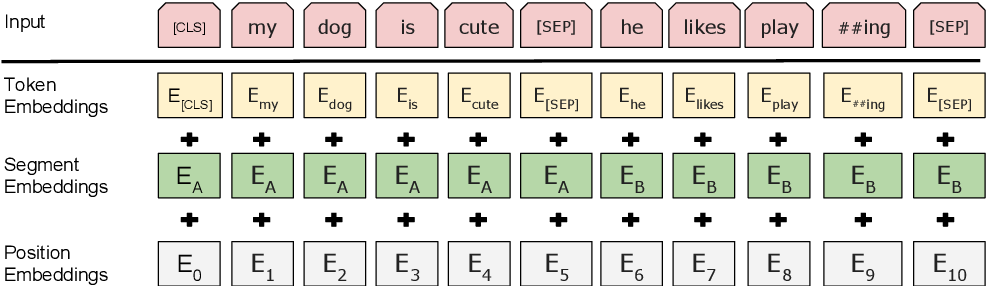

In [40]:
Image("img/dl/bert_embedding.png")

## Transformer layers


## Finetuning

1. Take a trained BERT model.
2. Add a small classification layer on top (typically a 2-layer MLP).
3. Train BERT along with the classification layer on an annotated dataset.
    - Much smaller than the data BERT was trained on

Another option: freeze BERT and train the classification layer only.
- Easier training regime.
- Smaller memory footprint.
- Worse performance.

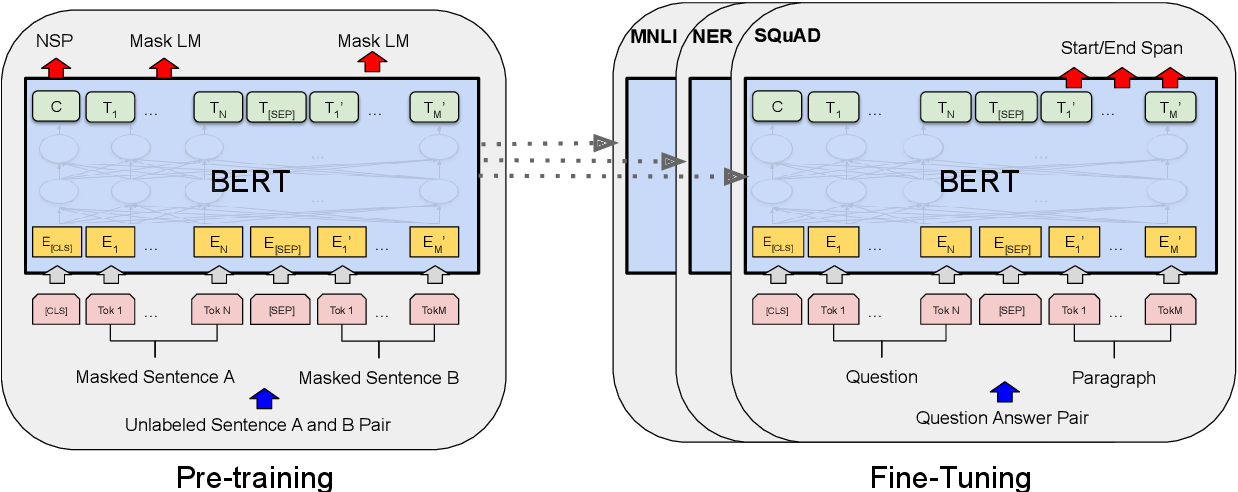

In [41]:
Image("img/dl/bert_encoding_finetuning.png")

## BERT pretrained checkpoints

### BERT-Base

- 12 layers
- 12 attention heads per layer
- 768 hidden size
- 110M parameters

### BERT-Large

- 24 layers
- 16 attention heads per layer
- 1024 hidden size
- 340M parameters

### Cased and uncased

Uncased: everything is lowercased. Diacritics are removed.

### Multilingual BERT - mBERT

104 language version trained on the 100 largest Wikipedia.

## BERT implementations

[Original Tensorflow implementation](https://github.com/google-research/bert)

[Huggingface Transformers](https://huggingface.co/transformers/)
- PyTorch implementation originally for BERT-only
- Now it supports dozens of other models
- Hundreds of other model checkpoints from the community

# BERT tokenization

## WordPiece tokenizer

BERT's input **must** be tokenized with BERT's own tokenizer.

A middle ground between word and character tokenization.

Static vocabulary:
- Byte-pair encoding: simple frequency-based tokenization method
- Continuation symbols (\#\#symbol)
- Special tokens: `[CLS]`, `[SEP]`, `[MASK]`, `[UNK]`
- It tokenizes everything, falling back to characters and `[UNK]` if necessary

`AutoTokenizer` is a factory class for pretrained tokenizers. ng id. `from_pretrained` instantiates the corresponding class and loads the weights:

In [42]:
t = AutoTokenizer.from_pretrained('bert-base-uncased')
print(type(t))
print(len(t.get_vocab()))

t.tokenize("My beagle's name is Tündérke.")

<class 'transformers.tokenization_bert.BertTokenizer'>
30522


['my', 'bea', '##gle', "'", 's', 'name', 'is', 'tun', '##der', '##ke', '.']

In [43]:
t.tokenize("Русский")

['р', '##у', '##с', '##с', '##к', '##ии']

**Cased** models keep diacritics:

In [47]:
t = AutoTokenizer.from_pretrained('bert-base-cased')
print(len(t.get_vocab()))

t.tokenize("My beagle's name is Tündérke.")

28996


['My',
 'be',
 '##ag',
 '##le',
 "'",
 's',
 'name',
 'is',
 'T',
 '##ü',
 '##nd',
 '##é',
 '##rk',
 '##e',
 '.']

It character tokenizes Chinese and Japanese but doesn't know all the characters:

In [48]:
t.tokenize("日本語")

['日', '本', '[UNK]']

Korean is missing from this version:

In [49]:
t.tokenize("한 한국어")

['한', '[UNK]']

## mBERT tokenization

104 languages, 1 vocabulary

In [50]:
t = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [51]:
len(t.get_vocab())

119547

In [52]:
t.tokenize("My puppy's name is Tündérke.")

['My',
 'pu',
 '##ppy',
 "'",
 's',
 'name',
 'is',
 'T',
 '##ün',
 '##dé',
 '##rke',
 '.']

In [53]:
t.tokenize("한 한국어")

['한', '한국', '##어']

In [54]:
t.tokenize("日本語")

['日', '本', '語']

# Using BERT

## Using `BertModel` directly

`AutoModel`
- each pretrained checkpoint has a string id. `from_pretrained` instantiates the corresponding class and loads the weights:

In [55]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
model = AutoModel.from_pretrained('bert-base-cased')
type(model), type(tokenizer)

(transformers.modeling_bert.BertModel,
 transformers.tokenization_bert.BertTokenizer)

In [56]:
tokenizer.tokenize("There are black cats and black dogs.")

['There', 'are', 'black', 'cats', 'and', 'black', 'dogs', '.']

`__call__` return a dictionary of BERT's encoding:

In [57]:
tokenizer("There are black cats and black dogs.")

{'input_ids': [101, 1247, 1132, 1602, 11771, 1105, 1602, 6363, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

It can be used for pairs of sentences. Note the values of `token_type_ids`:

In [58]:
tokenizer("There are black cats and black dogs.", "Another sentence.")

{'input_ids': [101, 1247, 1132, 1602, 11771, 1105, 1602, 6363, 119, 102, 2543, 5650, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

It can be used for multiple sentences:

In [59]:
tokenizer(["There are black cats and black dogs.", "There are two white cats."])

{'input_ids': [[101, 1247, 1132, 1602, 11771, 1105, 1602, 6363, 119, 102], [101, 1247, 1132, 1160, 1653, 11771, 119, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

In [65]:
encoded = tokenizer(["There are black cats and black dogs.", "There are two white cats."], return_tensors='pt', padding=True)
encoded['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])

We need tensors as inputs for BERT:

In [66]:
encoded = tokenizer("There are black cats and black dogs.", return_tensors='pt')
encoded['input_ids'].size()

torch.Size([1, 10])

In [67]:
encoded

{'input_ids': tensor([[  101,  1247,  1132,  1602, 11771,  1105,  1602,  6363,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [68]:
output = model(**encoded, return_dict=True)
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [69]:
output['last_hidden_state'].size(), output['pooler_output'].size()

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

Getting all layers:

In [70]:
output = model(**encoded, output_hidden_states=True, return_dict=True)
output.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [71]:
len(output['hidden_states']), output['hidden_states'][0].size()

(13, torch.Size([1, 10, 768]))

Remove variable from the global namespace, run the garbage collector:

In [72]:
del model
gc.collect()

398

## BERT applications

### Sequence classification

Pretrained model for sentiment analysis.

Base model: `distilbert-base-uncased`

Finetuned on the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) or SST-2, a popular sentiment analysis dataset.

Model id: `distilbert-base-uncased-finetuned-sst-2-english`

In [73]:
nlp = pipeline("sentiment-analysis")
nlp("This is an amazing class.")

[{'label': 'POSITIVE', 'score': 0.9998814463615417}]

In [74]:
nlp("This is not a good class but it's not too bad either.")

[{'label': 'POSITIVE', 'score': 0.9302219152450562}]

In [75]:
nlp("This is not a class.")

[{'label': 'NEGATIVE', 'score': 0.9993655681610107}]

In [76]:
del nlp
gc.collect()

287

### Sequence tagging/labeling: Named entity recognition

Base model: `bert-large-cased`

Finetuned on [CoNLL-2003 NER](https://www.clips.uantwerpen.be/conll2003/ner/).

In [77]:
nlp = pipeline("ner")

In [80]:
result = nlp("Jupiter is a planet that orbits around James the center of the Universe")
result

[{'word': 'Jupiter',
  'score': 0.917730450630188,
  'entity': 'I-LOC',
  'index': 1},
 {'word': 'James', 'score': 0.5041977167129517, 'entity': 'I-LOC', 'index': 8},
 {'word': 'Universe',
  'score': 0.5249300599098206,
  'entity': 'I-LOC',
  'index': 13}]

In [81]:
result = nlp("George Clooney has a pet pig named Estella.")
result

[{'word': 'George',
  'score': 0.9989229440689087,
  'entity': 'I-PER',
  'index': 1},
 {'word': 'C', 'score': 0.9973233938217163, 'entity': 'I-PER', 'index': 2},
 {'word': '##lo', 'score': 0.9540075063705444, 'entity': 'I-PER', 'index': 3},
 {'word': '##oney',
  'score': 0.9897923469543457,
  'entity': 'I-PER',
  'index': 4},
 {'word': 'E', 'score': 0.9577357769012451, 'entity': 'I-PER', 'index': 10},
 {'word': '##ste',
  'score': 0.9451481103897095,
  'entity': 'I-PER',
  'index': 11},
 {'word': '##lla', 'score': 0.865635097026825, 'entity': 'I-PER', 'index': 12}]

In [82]:
del nlp
gc.collect()

1706

### Machine translation

In [83]:
nlp = pipeline("translation_en_to_fr")
print(nlp("Hugging Face is a technology company based in New York and Paris", max_length=40))

Some weights of T5Model were not initialized from the model checkpoint at t5-base and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'translation_text': 'Hugging Face est une entreprise technologique basée à New York et à Paris.'}]


Even the [blessé - blessed false cognate](https://frenchtogether.com/french-english-false-friends/) is handled correctly:

In [84]:
nlp("I was blessed by God after I injured my head.", max_length=40)

[{'translation_text': "J'ai été béni par Dieu après avoir blessé ma tête."}]

In [85]:
gc.collect()

1082

In [86]:
del nlp
gc.collect()

20

### Masked language modeling

Uses `distilroberta-base`

In [87]:
nlp = pipeline("fill-mask")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
prompt = "Twitter is a bad idea /s> [MASK]"

for n in range(10):
    result = nlp(f"{prompt} {nlp.tokenizer.mask_token}")
    token = result[0]['token_str'][1:]
    prompt += " " + token
    
prompt

'Twitter is a bad idea /s> [MASK] /s> /s> /s> /s> /s> /s> END END END END'

In [89]:
from pprint import pprint
pred = nlp(f"HuggingFace is creating a {nlp.tokenizer.mask_token} that the community uses to solve NLP tasks.")
pprint(pred)

[{'score': 0.17927514016628265,
  'sequence': '<s>HuggingFace is creating a tool that the community uses to '
              'solve NLP tasks.</s>',
  'token': 3944,
  'token_str': 'Ġtool'},
 {'score': 0.11349447071552277,
  'sequence': '<s>HuggingFace is creating a framework that the community uses '
              'to solve NLP tasks.</s>',
  'token': 7208,
  'token_str': 'Ġframework'},
 {'score': 0.052435461431741714,
  'sequence': '<s>HuggingFace is creating a library that the community uses to '
              'solve NLP tasks.</s>',
  'token': 5560,
  'token_str': 'Ġlibrary'},
 {'score': 0.03493537753820419,
  'sequence': '<s>HuggingFace is creating a database that the community uses '
              'to solve NLP tasks.</s>',
  'token': 8503,
  'token_str': 'Ġdatabase'},
 {'score': 0.028602318838238716,
  'sequence': '<s>HuggingFace is creating a prototype that the community uses '
              'to solve NLP tasks.</s>',
  'token': 17715,
  'token_str': 'Ġprototype'}]


In [90]:
pred = nlp(f"{nlp.tokenizer.mask_token} is a very good idea.")
pprint(pred)

[{'score': 0.03921409323811531,
  'sequence': '<s>This is a very good idea.</s>',
  'token': 713,
  'token_str': 'This'},
 {'score': 0.02041138894855976,
  'sequence': '<s>That is a very good idea.</s>',
  'token': 1711,
  'token_str': 'That'},
 {'score': 0.018834417685866356,
  'sequence': '<s>It is a very good idea.</s>',
  'token': 243,
  'token_str': 'It'},
 {'score': 0.010761899873614311,
  'sequence': '<s>Which is a very good idea.</s>',
  'token': 32251,
  'token_str': 'Which'},
 {'score': 0.006242118775844574,
  'sequence': '<s>Bitcoin is a very good idea.</s>',
  'token': 42817,
  'token_str': 'Bitcoin'}]


In [91]:
pred = nlp(f"{nlp.tokenizer.mask_token} is a bad idea.")
pprint(pred)

[{'score': 0.03035598248243332,
  'sequence': '<s>This is a bad idea.</s>',
  'token': 713,
  'token_str': 'This'},
 {'score': 0.017567547038197517,
  'sequence': '<s>That is a bad idea.</s>',
  'token': 1711,
  'token_str': 'That'},
 {'score': 0.011682895012199879,
  'sequence': '<s>It is a bad idea.</s>',
  'token': 243,
  'token_str': 'It'},
 {'score': 0.010721716098487377,
  'sequence': '<s>Which is a bad idea.</s>',
  'token': 32251,
  'token_str': 'Which'},
 {'score': 0.008407930843532085,
  'sequence': '<s>Twitter is a bad idea.</s>',
  'token': 22838,
  'token_str': 'Twitter'}]


In [92]:
del nlp
gc.collect()

337

# Other models

## Pretrained models

RoBERTa: identical model, larger training data, different training objective

DistilBERT: smaller version of BERT. It was _distilled_ or compressed from BERT with a student-teacher setup.

ALBERT: smaller BERT

XLM-RoBERTa: multilingual version of RoBERTa

Distil-mBERT: distilled multilingual BERT

## Community models

[Over 1000 community contributions](https://huggingface.co/models)

## huBERT

The first Hungarian-only model and the only one registered on Huggingface.
Other models are available at https://hilanco.github.io/.

BERT base, trained on Webcorpus 2.0, a version of CommonCrawl.

Its tokenizer works much better for Hungarian than mBERT's:

In [93]:
hubert_tokenizer = AutoTokenizer.from_pretrained('SZTAKI-HLT/hubert-base-cc')
# hubert = AutoModel.from_pretrained('SZTAKI-HLT/hubert-base-cc')

In [94]:
sent = ("George Clooney Magyarországról szóló, az Orbán-kormányt kritizáló levelére miniszteri és "
        "államtitkári szinten is reagált a magyar kormány.")
hubert_tokenizer.tokenize(sent)

['George',
 'Cl',
 '##oo',
 '##ney',
 'Magyarországról',
 'szóló',
 ',',
 'az',
 'Orbán',
 '-',
 'kormányt',
 'krit',
 '##izáló',
 'level',
 '##ére',
 'miniszteri',
 'és',
 'államtitkár',
 '##i',
 'szinten',
 'is',
 'reagált',
 'a',
 'magyar',
 'kormány',
 '.']

In [95]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [96]:
bert_tokenizer.tokenize(sent)

['George',
 'Cl',
 '##oon',
 '##ey',
 'Magyarország',
 '##ról',
 'szóló',
 ',',
 'az',
 'Or',
 '##bán',
 '-',
 'kormány',
 '##t',
 'kr',
 '##iti',
 '##zá',
 '##ló',
 'level',
 '##ére',
 'mini',
 '##szter',
 '##i',
 'és',
 'állam',
 '##tit',
 '##kár',
 '##i',
 'szinte',
 '##n',
 'is',
 're',
 '##ag',
 '##ált',
 'a',
 'magyar',
 'kormány',
 '.']

## GPT-2 text generation

Causal language modeliing is when the $i^{th}$ token is modeled based on all the previous tokens as opposed to masked language modeling where both left and right context are used.

In [97]:
text_generator = pipeline("text-generation")

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [98]:
print(text_generator("This is a serious issue we should address", max_length=50, do_sample=False)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


This is a serious issue we should address," he said.

"We need to be able to do that. We need to be able to do that in a way that is fair and equitable."

Topics: government-and-politics


In [99]:
print(text_generator("Twitter is a bad idea, Jack Dorsey had a bad day when he came up with it", max_length=100, do_sample=False)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Twitter is a bad idea, Jack Dorsey had a bad day when he came up with it.

The idea of a "social media" is a bad idea.

The idea of a "social media" is a bad idea.

The idea of a "social media" is a bad idea.

The idea of a "social media" is a bad idea.

The idea of a "social media" is a bad idea.

The idea of


In [100]:
del text_generator
gc.collect()

742

# Further information

[Official PyTorch Transformer tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

[Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
- Famous blog post with a detailed gentle introduction to Transformers

[The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)
- A walkthrough of original Transformer paper with code and detailed illustration

[Huggingface Transformers - Summary of tasks](https://huggingface.co/transformers/task_summary.html)

[My blog post about mBERT's tokenizer](http://juditacs.github.io/2019/02/19/bert-tokenization-stats.html)